In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
N=1000

In [4]:
# Training data is N points in [0,10] inclusive regularly spaced
train_x = torch.linspace(0, 10, N, dtype=torch.float64)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)
# train_y = torch.sin(train_x * (2 * math.pi))

In [5]:
train_x.shape, train_y.shape

(torch.Size([1000]), torch.Size([1000]))

In [6]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=1)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

noises = torch.ones(N) * 0.001
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noises)
# likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(train_x, train_y, likelihood)

# As we are using float64 data, we need to convert our model to double
model.double()
likelihood.double()

FixedNoiseGaussianLikelihood(
  (noise_covar): FixedGaussianNoise()
)

In [7]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   num mixtures: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        0,
        0
#        model.covar_module.period_length.item(),
#        model.likelihood.noise.item()
    ))
    optimizer.step()

/Users/lgo/dev/kuleuven/thesis_wip/venv/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:266: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  _jit_linear_cg_updates_no_precond(


Iter 1/100 - Loss: 260.759   num mixtures: 0.000   noise: 0.000
Iter 2/100 - Loss: 265.704   num mixtures: 0.000   noise: 0.000
Iter 3/100 - Loss: 260.973   num mixtures: 0.000   noise: 0.000
Iter 4/100 - Loss: 261.705   num mixtures: 0.000   noise: 0.000
Iter 5/100 - Loss: 263.404   num mixtures: 0.000   noise: 0.000
Iter 6/100 - Loss: 262.630   num mixtures: 0.000   noise: 0.000
Iter 7/100 - Loss: 261.002   num mixtures: 0.000   noise: 0.000
Iter 8/100 - Loss: 260.196   num mixtures: 0.000   noise: 0.000
Iter 9/100 - Loss: 260.834   num mixtures: 0.000   noise: 0.000
Iter 10/100 - Loss: 261.555   num mixtures: 0.000   noise: 0.000
Iter 11/100 - Loss: 261.390   num mixtures: 0.000   noise: 0.000
Iter 12/100 - Loss: 260.571   num mixtures: 0.000   noise: 0.000
Iter 13/100 - Loss: 259.824   num mixtures: 0.000   noise: 0.000
Iter 14/100 - Loss: 259.770   num mixtures: 0.000   noise: 0.000
Iter 15/100 - Loss: 259.984   num mixtures: 0.000   noise: 0.000
Iter 16/100 - Loss: 260.071   num 

In [8]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

test_noises = torch.ones(980) * 0.01

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 10, 980, dtype=torch.float64)
    observed_pred = likelihood(model(test_x), test_noises)

/Users/lgo/dev/kuleuven/thesis_wip/venv/lib/python3.8/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


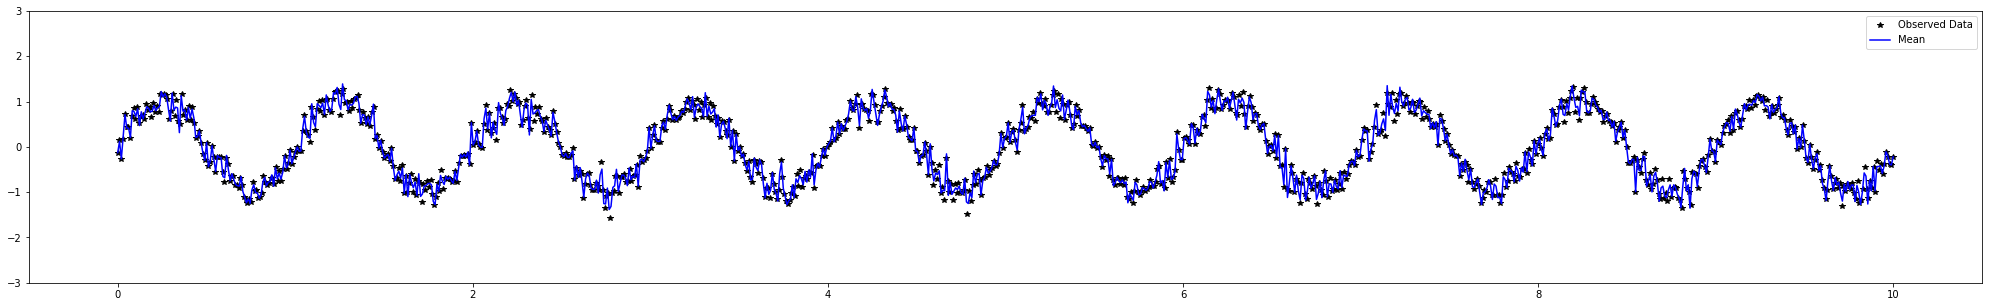

In [9]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(35, 5))

    # Get upper and lower confidence bounds
#    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
#    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])